What result do you get if you make greedy choices: at each step, try every possible elaboration, do a parameter optimization, and pick the elaboration that yields the most improvement...

Possible pitfall: "all possible elaborations" may be too many. How can we prioritize 

Related question: can you use the fact that we have gradients w.r.t. all per-particle parameters to help pick which ones need to be split?

In [1]:
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

In [2]:
import os.path
from autograd import numpy as np
from simtk import unit
from bayes_implicit_solvent.gb_models.obc2_parameters import obc2_model

from bayes_implicit_solvent.continuous_parameter_experiments.elemental_types_mh import log_prior, mols, ll, data_path, smiles


obc2_model.remove_node('[#14]')
mols = mols
type_slices = [obc2_model.apply_to_molecule(mol.mol) for mol in mols]



def construct_arrays(theta):
    n = int(len(theta) / 2)
    radii, scales = theta[:n], theta[n:]

    parameterized_list = []
    for i in range(len(mols)):
        parameterized_list.append((radii[type_slices[i]], scales[type_slices[i]]))
    return parameterized_list

smiles_list = smiles

elements = []
charges = []
distance_matrices = []
expt_means = []
expt_uncs = []
vacuum_trajs = []

n_configuration_samples = 25

name = 'n_config={}_{}_ll'.format(n_configuration_samples, ll)
smiles_subset_fname = os.path.join(data_path,
                                   'smiles_subset_{}.txt'.format(name))
with open(smiles_subset_fname, 'w') as f:
    f.writelines(['{}\n'.format(smiles) for smiles in smiles_list])

from bayes_implicit_solvent.utils import get_charges
from scipy.spatial.distance import pdist, squareform

for mol in mols:
    expt_means.append(mol.experimental_value)
    expt_uncs.append(mol.experimental_uncertainty)

    elements.append(np.array([a.element.atomic_number for a in mol.top.atoms()]))
    charges.append(get_charges(mol.sys))
    distance_matrices.append([squareform(pdist(snapshot / unit.nanometer)) for snapshot in mol.vacuum_traj])

# 2. Define a likelihood function, including "type-assignment"
from autograd import numpy as np
from autograd.scipy.stats import norm
from autograd.scipy.stats import t as student_t
from autograd import grad
from autograd.scipy.misc import logsumexp
from simtk import unit
from bayes_implicit_solvent.constants import kB, temperature

kj_mol_to_kT = 1.0 * unit.kilojoule_per_mole / (kB * temperature)

def one_sided_exp(w_F):
    DeltaF = - (logsumexp(- w_F) - np.log(len(w_F)))
    return DeltaF


from bayes_implicit_solvent.gb_models.numpy_gb_models import compute_OBC_energy_vectorized


def blown_up_grad_log_likelihood(theta):
    """Note that this doesn't include prior!"""
    parameterized_list = construct_arrays(theta)

    def per_atom_log_prob(parameterized_list):
        L = 0
        for i in range(len(mols)):
            radii, scales = parameterized_list[i]
            W_F = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges[i]) for distance_matrix in
                            distance_matrices[i]])
            w_F = W_F * kj_mol_to_kT
            pred_free_energy = one_sided_exp(w_F)

            L += norm.logpdf(pred_free_energy, loc=expt_means[i], scale=expt_uncs[i] ** 2)
        return L
    
    return grad(per_atom_log_prob)(parameterized_list)

number of molecules being considered: 321
first few CIDs ['mobley_3187514', 'mobley_900088', 'mobley_766666', 'mobley_5056289', 'mobley_4630641']
discarding c1c(=O)[nH]c(=O)[nH]c1Cl (mobley_4338603) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)Cl (mobley_9557440) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1ccc(cc1)n2c(=O)c(c(cn2)N)Cl (mobley_2523689) because its free energy was outside of the range [-15, +5] kcal/mol
discarding C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O (mobley_9534740) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)F (mobley_337666) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)I (mobley_2727678) because its free energy was outside of the range [-15, +5] kcal/mol


In [3]:
n_types = obc2_model.number_of_nodes
print('n_types: {}'.format(n_types))

#initial_radii = np.array(obc2_model.get_radii())
#initial_scales = np.array(obc2_model.get_scale_factors())
#theta0 = np.hstack((initial_radii, initial_scales))

theta0 = np.array([0.15490722, 0.04773736, 0.16941407, 0.18453076, 0.16808416,
       0.18874551, 0.24982275, 0.24191997, 0.99817436, 0.74632998,
       0.90633359, 0.75123646, 0.80444066, 0.73795263, 0.48489181,
       1.01444513])

n_types: 8


In [4]:
grads = blown_up_grad_log_likelihood(theta0)

In [30]:
grads[0]

(array([ 1.75382945e+02,  9.12095695e+01,  3.44377883e+02,  4.04014647e+02,
         1.64896966e+02,  3.23215046e+02,  1.39574495e+03,  4.67366894e+03,
        -8.29829455e-01,  4.57781203e+00,  5.80913216e+00,  9.95223131e+01,
         4.23830934e+01,  2.41656804e+02, -4.77503775e+01,  1.87189501e+03,
         5.55239567e+02]),
 array([1.69588745e+01, 2.89313019e+01, 5.02529919e+01, 4.93932025e+01,
        1.19879808e+01, 4.01731664e+01, 2.16806371e+02, 9.54088999e+02,
        4.22783063e-01, 3.12828823e-01, 2.80709585e-01, 3.03867821e-01,
        1.65537032e-01, 3.54303136e-01, 1.92625865e-01, 1.68022397e-01,
        3.46315162e-01]))

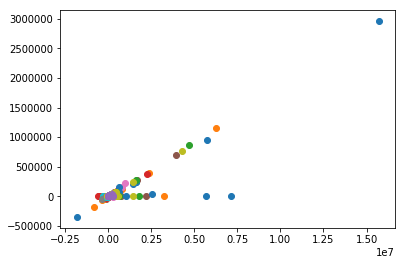

In [32]:
xs = []
ys = []
for g in grads:
    xs.append(g[0])
    ys.append(g[1])
    plt.scatter(g[0], g[1])

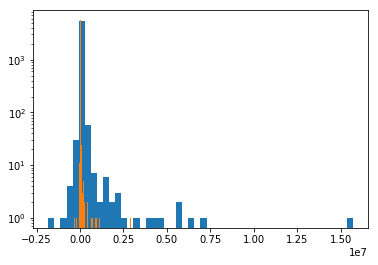

In [37]:
plt.hist(np.hstack(xs), bins=50)
plt.yscale('log')

plt.hist(np.hstack(ys), bins=50)
plt.yscale('log')

In [28]:
g[0]

array([ 11.93845516,   8.43699361,  12.36765234,  25.08984674,
        39.25298607, 226.61570025, 253.89873867, 702.95421023,
        -7.70199833,  -0.98716132,  -2.56502017, -10.1553225 ,
        -5.89621847, -17.37296236,  -9.1799359 ,   1.4700532 ,
         1.64354847,  13.66966301,   3.88453485, 118.53600066,
       163.54535732])

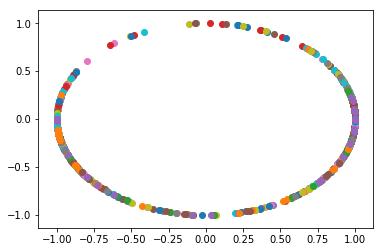

In [49]:
all_vecs = []
for g in grads:
    vecs = np.vstack((g[0], g[1]))
    vecs /= np.linalg.norm(vecs, axis=0)
    all_vecs.append(vecs)
    
    plt.scatter(vecs[0], vecs[1])

In [50]:
all_vecs = np.hstack(all_vecs)

In [51]:
len(all_vecs[0])

5634

In [52]:
c = np.hstack(type_slices)
n = len(c)

In [53]:
len(set(c))

8

Text(0, 0.5, '$\\partial L / \\partial s$')

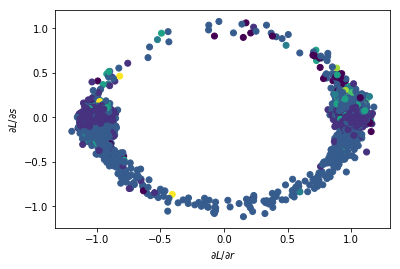

In [54]:
sigma = 0.05
plt.scatter(all_vecs[0] + sigma * np.random.randn(n), all_vecs[1] + sigma * np.random.randn(n), c=c)
plt.xlabel(r'$\partial L / \partial r$')
plt.ylabel(r'$\partial L / \partial s$')

In [55]:
obc2_model.ordered_nodes

['*', '[#1]', '[#6]', '[#7]', '[#8]', '[#9]', '[#15]', '[#16]']

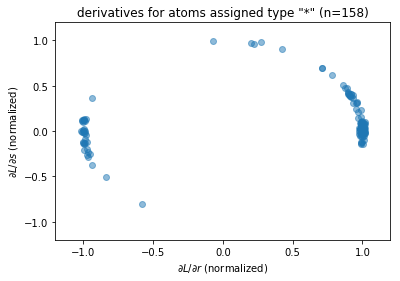

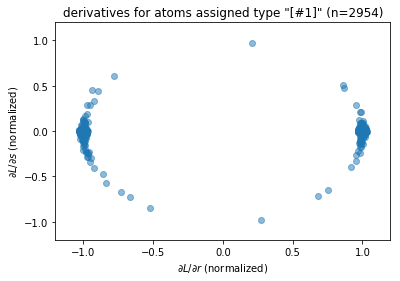

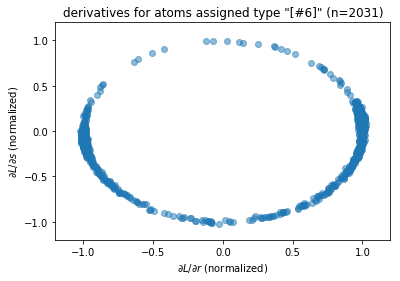

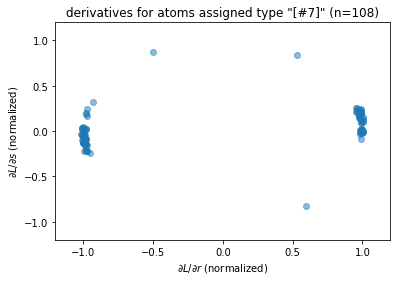

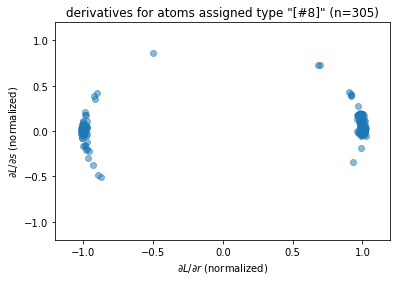

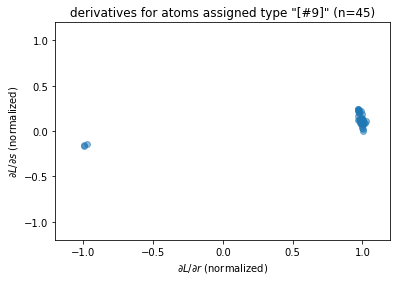

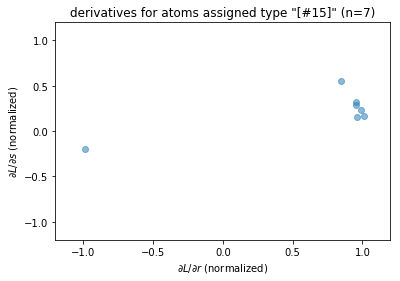

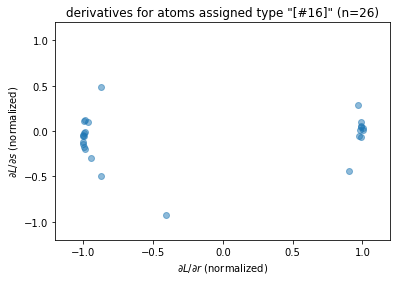

In [56]:
sigma = 0.01

for i in sorted(list(set(c))):
    plt.figure()
    mask = c==i
    
    n = sum(mask)
    plt.scatter(all_vecs[0][mask] + sigma * np.random.randn(n),
                all_vecs[1][mask] + sigma * np.random.randn(n),
                alpha=0.5
               )
    plt.xlabel(r'$\partial L / \partial r$ (normalized)')
    plt.ylabel(r'$\partial L / \partial s$ (normalized)')
    
    node = obc2_model.ordered_nodes[i]
    plt.title('derivatives for atoms assigned type "{}" (n={})'.format(node, n))
    
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)

# next: color these dots by possible refinements of the chemical environment

Also, color by smirnoff nb type

Also, make an animation of how this changes over the course of sampling, esp. what happens when you introduce more types.

Also, figure out what to do with the *magnitude* of these vectors...

Replace with an entropy thing

In [57]:
vecs = np.vstack((g[0], g[1]))

In [16]:
vecs /= np.linalg.norm(vecs, axis=0)

In [17]:
vecs

array([[-0.9721501 , -0.93586995, -0.91044785, -0.99958544, -0.96357547,
        -0.99210262, -0.99093327, -0.99325478, -0.99291634],
       [ 0.2343591 ,  0.35234562,  0.41362387,  0.02879161,  0.26743655,
         0.12542881,  0.13435494,  0.11595235,  0.11881559]])

In [19]:
X = all_vecs.T
X.shape

(5634, 2)

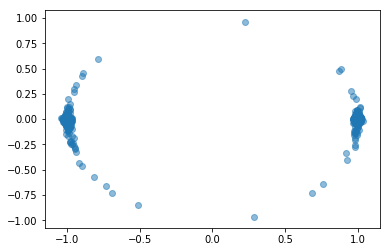

In [38]:
mask = c==1

n = sum(mask)


plt.scatter(all_vecs[0][mask] + sigma * np.random.randn(n),
            all_vecs[1][mask] + sigma * np.random.randn(n),
            alpha=0.5
           )

In [40]:
np.mean(all_vecs[0][mask] < 0)

0.46750169262017605